In [90]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

## Import Libraries

In [1]:
import csv
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings 
import gensim 
from gensim.models import Word2Vec 
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings(action = 'ignore') 

C:\Users\lukes\Anaconda3\lib\site-packages\funcy\colls.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable, Iterator, defaultdict
C:\Users\lukes\Anaconda3\lib\site-packages\funcy\colls.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable, Iterator, defaultdict
C:\Users\lukes\Anaconda3\lib\site-packages\funcy\decorators.py:63: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  spec = inspect.getargspec(func)
C:\Users\lukes\Anaconda3\lib\site-packages\funcy\decorators.py:63: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  spec = inspect.get

## Import Data

WARNING: this takes a long time to load. 

In [2]:
data = pd.read_csv('hansard-1979-2018-v261.csv',engine='python')

## Clean Data

We're only interested in the name of the MP, their party, and the words in their speech. We can drop the rest.

In [4]:
data = data.drop(['pp_id','eo_id','colnum','speech_date','time',
                 'url','speaker_id','gender','dods_id','pims_id','ministry',
                  'age','short_list','post_name'],axis=1)

In [5]:
data = data.drop(['person_id','hansard_membership_id','mnis_id','house_start_date','date_of_birth',
                 'house_end_date','word_count'],axis=1)

Because the speaker of the house is impartial, we need to remove his speeches from the dataset.

In [6]:
is_not_speaker = data['as_speaker']==False

In [7]:
data = data[is_not_speaker]

In [8]:
data['as_speaker'].value_counts()

False    2175726
Name: as_speaker, dtype: int64

For testing purposes, I'll reduce the size of the database to only include speeches made since the year 2000. 

In [9]:
year_2000 = data['year']>=2000

In [10]:
data = data[year_2000]

Export the cleaned dataset to csv.

In [12]:
data.to_csv('cleaned_data.csv')

## Data Exploration

Explore the number of MPs, number of speeches by political party.

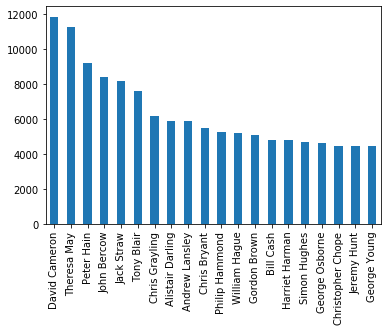

In [14]:
data['proper_name'].value_counts().head(20).plot.bar()

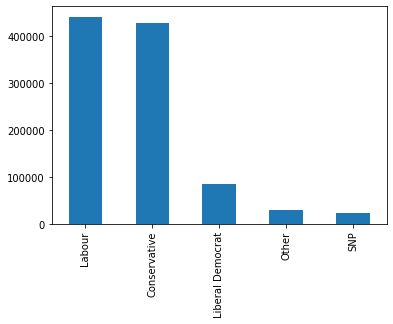

In [15]:
data['party_group'].value_counts().plot.bar()

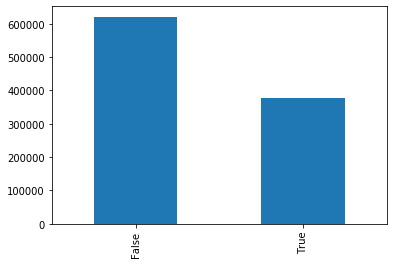

In [16]:
data['government'].value_counts().plot.bar()

## Preparing Text for Analysis

In [18]:
def clean_up(s):
    """
    Cleans up numbers, URLs, and special characters from a string.

    Args:
        s: The string to be cleaned up.

    Returns:
        A string that has been cleaned up.
    """
    new_string = re.sub(r'^https?:\/\/.*[\r\n]*', '', s
                       ) 
    new_string = re.sub('\d+', '', new_string
                       )
    new_string = re.sub('[^\w\s]', ' ', new_string
                       )
    return new_string.lower()

In [19]:
def tokenize(s):
    """
    Tokenize a string.

    Args:
        s: String to be tokenized.

    Returns:
        A list of words as the result of tokenization.
    """
    return nltk.word_tokenize(s)

In [20]:
def stem_and_lemmatize(l):
    """
    Perform stemming and lemmatization on a list of words.

    Args:
        l: A list of strings.

    Returns:
        A list of strings after being stemmed and lemmatized.
    """
    ps = PorterStemmer()
    new_l = ([ps.stem(w) for w in l]
         )

    lemmatizer = WordNetLemmatizer()
    new_l = ([lemmatizer.lemmatize(w) for w in new_l]
            ) 
    
    return new_l

Create a new, smaller dataset to manipulate.

In [22]:
cleaned_data = data.head(100000)

Clean up data.

In [23]:
cleaned_data['speech'] = cleaned_data['speech'].apply(lambda x: clean_up(x))

Tokenize.

In [24]:
cleaned_data['speech'] = cleaned_data['speech'].apply(lambda x: tokenize(x))

Stem and Lemmatize.

In [25]:
cleaned_data['speech'] = cleaned_data['speech'].apply(lambda x: stem_and_lemmatize(x))

Remove stopwords.

In [26]:
stop_words = stopwords.words('english')
cleaned_data['speech'] = cleaned_data['speech'].apply(lambda x: [item for item in x if item not in stop_words])

Store final database in new variable and export to .csv.

In [28]:
cleaned_data_final = cleaned_data

In [29]:
cleaned_data_final.to_csv('cleaned_data_final.csv')

### Make Bag of Words

In [30]:
all_words = [j for i in cleaned_data_final['speech'].tolist() for j in i]

In [31]:
all_words = nltk.FreqDist(all_words)

In [32]:
len(all_words)

44725

### Remove procedural language (such as "Right Hon. Friend" 

In [ ]:
proc_lang = [parliament,opposit,vote,motion,speech,speaker,select,leader,prime,chamber,answer,lord,ladi,back,second,day,ciew,read,today]
for i in cleaned_data_final['speech'].head():
    print(i)

### Build Features

In [33]:
cleaned_data_final.head()

,speech,as_speaker,proper_name,party,party_group,government
1173494,"[step, govern, take, ensur, sever, disabl, peo...",False,Andrew George,Liberal Democrat,Liberal Democrat,False
1173495,"[sever, disabl, allow, doe, provid, suffici, h...",False,Hugh Bayley,Labour,Labour,True
1173496,"[essenti, rais, standard, examin, sever, const...",False,Jonathan Shaw,Labour,Labour,True
1173497,"[simpl, answer, final, point, ye, overwhelm, m...",False,Hugh Bayley,Labour,Labour,True
1173498,"[make, statement, work, load, independ, case, ...",False,Caroline Spelman,Conservative,Conservative,False


In [34]:
word_features = list(all_words.keys())

In [35]:
documents = list(zip(cleaned_data_final['speech'], np.where(cleaned_data_final['party_group'] == 'Labour', True, False)))

In [36]:
documents_short = documents[:1000]

In [37]:
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features

In [38]:
featuresets = [(find_features(rev), category) for (rev, category) in documents_short]

In [39]:
len(featuresets)

1000

In [40]:
training_set = featuresets[:800]
testing_set = featuresets[800:]

In [41]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [42]:
print("Classifier accuracy:",(nltk.classify.accuracy(classifier, testing_set)))
classifier.show_most_informative_features(20)

Classifier accuracy: 0.465
Most Informative Features
                  reject = True            False : True   =     10.5 : 1.0
                   logic = True            False : True   =      9.6 : 1.0
                 neither = True            False : True   =      8.5 : 1.0
                  liabil = True            False : True   =      8.5 : 1.0
                 penalti = True            False : True   =      8.5 : 1.0
              furthermor = True            False : True   =      8.5 : 1.0
                partisan = True            False : True   =      7.4 : 1.0
               disincent = True            False : True   =      7.4 : 1.0
                withdraw = True            False : True   =      7.4 : 1.0
               terrorist = True            False : True   =      7.4 : 1.0
                  assert = True            False : True   =      6.6 : 1.0
                    wife = True            False : True   =      6.2 : 1.0
                   valid = True            Fals

## Word Vectors

In [43]:
model = gensim.models.Word2Vec(cleaned_data_final['speech'], min_count = 1,  
                              size = 100, window = 5) 

In [44]:
print("Cosine similarity between 'reject' " + 
               "and 'islam' - CBOW : ", 
    model.similarity('penalti', 'echo')) 

Cosine similarity between 'reject' and 'islam' - CBOW :  -0.27748135


In [45]:
all_words

FreqDist({'hon': 139446, 'ha': 90689, 'govern': 87521, 'member': 86719, 'wa': 86257, 'would': 73352, 'right': 66435, 'thi': 58067, 'friend': 57176, 'peopl': 55105, ...})

In [46]:
dictionary = gensim.corpora.Dictionary(cleaned_data_final['speech'])

In [47]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 allow
1 claim
2 disabl
3 elig
4 encourag
5 ensur
6 govern
7 peopl
8 potenti
9 sever
10 step


In [48]:
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [49]:
bow_corpus = [dictionary.doc2bow(i) for i in cleaned_data_final['speech']]

In [50]:
document_num = 404
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 123 ("child") appears 3 time.
Word 160 ("arrang") appears 1 time.
Word 171 ("best") appears 1 time.
Word 318 ("larg") appears 1 time.
Word 447 ("separ") appears 1 time.
Word 449 ("set") appears 1 time.
Word 478 ("talk") appears 1 time.
Word 848 ("quit") appears 1 time.
Word 1129 ("prepar") appears 2 time.
Word 1384 ("togeth") appears 1 time.
Word 1517 ("percentag") appears 1 time.
Word 1671 ("enter") appears 1 time.
Word 1752 ("mainten") appears 1 time.
Word 1753 ("parent") appears 2 time.
Word 2334 ("divorc") appears 1 time.
Word 2443 ("bureaucraci") appears 1 time.
Word 2783 ("straightforward") appears 1 time.
Word 3590 ("lawyer") appears 1 time.
Word 3631 ("panopli") appears 1 time.


## Running LDA

In [51]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

In [52]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.015*"amend" + 0.011*"claus" + 0.010*"legisl" + 0.009*"act" + 0.008*"provis" + 0.007*"power" + 0.007*"regul" + 0.007*"court" + 0.006*"law" + 0.006*"inform"


Topic: 1 
Words: 0.009*"defenc" + 0.009*"forc" + 0.007*"diseas" + 0.007*"farmer" + 0.007*"farm" + 0.006*"anim" + 0.006*"food" + 0.006*"afghanistan" + 0.005*"arm" + 0.005*"militari"


Topic: 2 
Words: 0.106*"n" + 0.013*"european" + 0.013*"c" + 0.010*"unit" + 0.008*"ireland" + 0.008*"northern" + 0.007*"intern" + 0.006*"union" + 0.006*"british" + 0.006*"world"


Topic: 3 
Words: 0.022*"school" + 0.015*"educ" + 0.010*"industri" + 0.008*"area" + 0.008*"develop" + 0.007*"teacher" + 0.007*"job" + 0.006*"rural" + 0.006*"employ" + 0.006*"fund"


Topic: 4 
Words: 0.021*"health" + 0.016*"per" + 0.015*"cent" + 0.009*"increas" + 0.009*"nh" + 0.008*"spend" + 0.008*"invest" + 0.008*"patient" + 0.008*"money" + 0.007*"care"


Topic: 5 
Words: 0.022*"local" + 0.017*"child" + 0.015*"author" + 0.014*"polic" + 0.011*"n" + 0.010*"home

In [53]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=cleaned_data_final['speech'], 
                                     dictionary=dictionary, 
                                     coherence='c_v'
                                    )
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.649136725298915

Coherence Score:  0.4881189170203751


Perplexity captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set.

## Visualise Topic Keywords

This examines the topics and the keywords that are associated with them.

It uses the pyLDAvis package’s interactive chart.

In [56]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

In [57]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.100255 -0.111087       1        1  19.600864
0      0.128178 -0.117213       2        1  17.705942
5     -0.022289  0.053146       3        1  12.723424
3     -0.090229  0.083503       4        1  10.553045
2      0.147297  0.088649       5        1  10.326722
7     -0.151059 -0.103015       6        1  10.155960
4     -0.155343 -0.008473       7        1   9.578747
1      0.043190  0.114490       8        1   9.355292, topic_info=     Category          Freq      Term         Total  loglift  logprob
5849  Default  83751.000000         n  83751.000000  30.0000  30.0000
330   Default  22421.000000     local  22421.000000  29.0000  29.0000
2078  Default  15676.000000    school  15676.000000  28.0000  28.0000
479   Default  13848.000000       tax  13848.000000  27.0000  27.0000
1584  Default  15403.000000    health  15403.000000  26.0000  26.0000
788   Default  19355.000000     amend  19355.000000  25.0000  25.0000
129   Default  11044.000000   pension  11044.000000  24.0000  24.0000
123   Default  18841.000000     child  18841.000000  23.0000  23.0000
376   Default  17779.000000       per  17779.000000  22.0000  22.0000
1877  Default  13008.000000     polic  13008.000000  21.0000  21.0000
193   Default  12863.000000     claus  12863.000000  20.0000  20.0000
167   Default  17789.000000    author  17789.000000  19.0000  19.0000
1676  Default  11237.000000      educ  11237.000000  18.0000  18.0000
188   Default  16249.000000      cent  16249.000000  17.0000  17.0000
258   Default   9959.000000  european   9959.000000  16.0000  16.0000
246   Default  13843.000000     elect  13843.000000  15.0000  15.0000
113   Default  17216.000000    legisl  17216.000000  14.0000  14.0000
1263  Default  14527.000000      busi  14527.000000  13.0000  13.0000
298   Default  14253.000000      home  14253.000000  12.0000  12.0000
12    Default  12116.000000   benefit  12116.000000  11.0000  11.0000
347   Default  12613.000000     money  12613.000000  10.0000  10.0000
1103  Default  14369.000000   increas  14369.000000   9.0000   9.0000
1327  Default  13319.000000  industri  13319.000000   8.0000   8.0000
1868  Default   6048.000000        nh   6048.000000   7.0000   7.0000
2444  Default  17171.000000         c  17171.000000   6.0000   6.0000
206   Default  10195.000000      cost  10195.000000   5.0000   5.0000
1083  Default  15072.000000      care  15072.000000   4.0000   4.0000
1681  Default   5820.000000     incom   5820.000000   3.0000   3.0000
1075  Default  15534.000000      area  15534.000000   2.0000   2.0000
636   Default  11672.000000      unit  11672.000000   1.0000   1.0000
...       ...           ...       ...           ...      ...      ...
1161   Topic8   1354.795044    deploy   1422.024170   2.3208  -6.1398
670    Topic8   5480.855469    defenc   6441.772461   2.2077  -4.7422
5456   Topic8   1258.531006   fisheri   1327.456421   2.3159  -6.2135
4775   Topic8   3103.546875  militari   3591.427979   2.2232  -5.3109
4480   Topic8    892.670288     marin    924.275757   2.3344  -6.5570
4598   Topic8   1027.957886     troop   1088.771729   2.3118  -6.4159
2210   Topic8   3293.404541       arm   4150.833984   2.1378  -5.2515
1005   Topic8   3039.071777      foot   3798.839844   2.1461  -5.3319
3357   Topic8    967.817566  scientif   1032.541748   2.3045  -6.4761
6504   Topic8    835.527222    infect    861.461060   2.3387  -6.6231
2245   Topic8   5407.425781      forc  10038.599609   1.7506  -4.7557
544    Topic8   2087.972412     crisi   3234.348633   1.9316  -5.7072
3390   Topic8   1228.205688     flood   1520.724854   2.1556  -6.2379
1303   Topic8   1525.266113    export   2141.326904   2.0300  -6.0213
641    Topic8   1811.918945       war   3131.488037   1.8221  -5.8490
2755   Topic8   1699.825195   compens   2836.110840   1.8573  -5.9129
69     Topic8   2442.530029   control   5931.612305   1.4

Each bubble represents a topic. The larger the bubble, the more common the topic is. 

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

We have two topics in each quandrant, and only two overlapping bubbles. Therefore, this seems to be a good topic model.

## Find optimum number of Topics

In [ ]:
# To do!

## Find Dominant Topic in each Speech

In [87]:
def format_topics_sentences(ldamodel=lda_model, bow_corpus=bow_corpus, texts=cleaned_data_final['speech']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[bow_corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    return(sent_topics_df)

In [124]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, bow_corpus=bow_corpus, texts=cleaned_data_final['speech'])

In [290]:
test_data = df_topic_sents_keywords.drop('MP',axis=1)

In [292]:
test_data = test_data.reset_index(drop=True).merge(cleaned_data_final['proper_name'].reset_index(drop=True), left_index=True, right_index=True)

In [293]:
test_data = test_data.reset_index(drop=True).merge(cleaned_data_final['party_group'].reset_index(drop=True), left_index=True, right_index=True)

In [295]:
test_data['Dominant_Topic'] = test_data['Dominant_Topic'].astype(int)

In [296]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'MP']

## Create new column, grouping by MP, aggregating by number of speeches made about a given topic. 

In [297]:
test_data = test_data.pivot_table(index='proper_name', columns='Dominant_Topic', aggfunc='count',fill_value=0)

In [298]:
test_data.head()

Perc_Contribution                            Topic_Keywords  \
Dominant_Topic                 0   1    2   3  4   5   6  7              0   
proper_name                                                                  
Adam Ingram                   64  45  103  14  3  19  27  6             64   
Adam Price                     0   0    1   7  8   0   2  3              0   
Adrian Bailey                  1   2    3   5  1   5   1  1              1   
Adrian Flook                   0   0    0   3  0   1   0  1              0   
Adrian Sanders                 4   1    1   7  2  17   6  7              4   

                    ...        party_group                             
Dominant_Topic   1  ...   6  7           0   1    2   3  4   5   6  7  
proper_name         ...                                                
Adam Ingram     45  ...  27  6          64  45  103  14  3  19  27  6  
Adam Price       0  ...   2  3           0   0    1   7  8   0   2  3  
Adrian Bailey    2  ...   1  1           1   2    3   5  1   5   1  1  
Adrian Flook     0  ...   0  1           0   0    0   3  0   1   0  1  
Adrian Sanders   1  ...   6  7           4   1    1   7  2  17   6  7  

[5 rows x 24 columns]

In [299]:
test_data.columns = test_data.columns.droplevel()

In [300]:
model_data = test_data.iloc[: , [1,2,3,4,5,6,7]]

In [301]:
model_data = pd.merge(model_data, cleaned_data_final, how='left', on="proper_name")

In [302]:
model_data = model_data.drop_duplicates(subset="proper_name")

In [303]:
model_data = model_data.drop(['speech','as_speaker','party','government'],axis=1)

In [304]:
model_data = model_data.reset_index()

In [305]:
model_data = model_data.drop('index',axis=1)

In [307]:
model_data.head(10)

,proper_name,1,2,3,4,5,6,7,party_group
0,Adam Ingram,45,103,14,3,19,27,6,Labour
1,Adam Price,0,1,7,8,0,2,3,Other
2,Adrian Bailey,2,3,5,1,5,1,1,Labour
3,Adrian Flook,0,0,3,0,1,0,1,Conservative
4,Adrian Sanders,1,1,7,2,17,6,7,Liberal Democrat
5,Alan Beith,16,5,6,14,2,25,4,Liberal Democrat
6,Alan Campbell,4,0,2,0,1,0,1,Labour
7,Alan Duncan,8,5,9,2,0,22,14,Conservative
8,Alan Haselhurst,0,1,0,0,0,5,0,Conservative
9,Alan Howarth,3,2,63,5,7,5,1,Labour


## Train machine learning algorithm on new dataframe.